# Package Imports

In [1]:
import numpy as np
import pandas as pd
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, MACCSkeys, Descriptors, Descriptors3D, Draw, rdMolDescriptors, Draw, PandasTools
from rdkit.DataManip.Metric.rdMetricMatrixCalc import GetTanimotoSimMat, GetTanimotoDistMat
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

random.seed(0)

# Database Processing

In [2]:
# Import Databases

Dens_data = np.load(r"../Databases/Database['Specific_density'] With PubChem - Updated 20230719-172934.pkl",allow_pickle = True) # Density data
Visc_data = np.load(r"../Databases/Database['Viscosity'] With PubChem - Updated 20230720-163216.pkl",allow_pickle = True) # Viscosoty data
Cond_data = np.load(r"../Databases/Database['Electrical_conductivity'] With PubChem - Updated 20230720-222648.pkl",allow_pickle = True) # Electrical Conductivity data
Heat_data = np.load(r"../Databases/Database['Heat_capacity_at_constant_pressure'] With PubChem - Updated 20230719-150517.pkl",allow_pickle = True) # Heat Capacity data
Melt_data = np.load(r"../Databases/Database['Normal_melting_temperature'] With PubChem - Updated 20230718-125617.pkl",allow_pickle = True) # Melting Temperature data
Visc_Dens_Cond_data = np.load(r"../Databases/Database['Electrical_conductivity', 'Viscosity', 'Specific_density'] With PubChem - Updated 20230720-141035.pkl",allow_pickle = True) # Data with density, viscosity, and molar conductivity from the same study
Ea_data = pd.read_csv(r"../Databases/Ea_Data.csv") # Activation energies and pre-exponential factors from data fit using the modified Arrhenius equation

# Obtain all avaialable SMILES

Dens_smiles = Dens_data[['Smiles_cation', 'Smiles_anion']]
Visc_smiles = Visc_data[['Smiles_cation', 'Smiles_anion']]
Cond_smiles = Cond_data[['Smiles_cation', 'Smiles_anion']]
Heat_smiles = Heat_data[['Smiles_cation', 'Smiles_anion']]
Melt_smiles = Melt_data[['Smiles_cation', 'Smiles_anion']]

All_smiles = pd.concat([Dens_smiles, Visc_smiles, Cond_smiles, Heat_smiles, Melt_smiles], ignore_index=True).drop_duplicates().dropna().reset_index(drop=True) # 630 Pure ILs

# Selecting viscosity, conductivity, and density data along with RDKit descriptors of interest

data = Visc_Dens_Cond_data[['compString', # name of ionic liquid
    'mmCation', # molecular mass of cation
    'mmAnion', # molecular mass of cation
    'Temperature', # Temperatures of viscosity and conductivity measurements
    'molarCond_Scm2mol', # Molar conductivity measurements
    'SimNernstEinstein_Scm2_mol', # Nernst-Einstein molar conductivity predictions using simulated molecular volumes and experimental viscosity
    'Viscosity', # Viscosity measurements
    'Specific_density', # Specific density measurements
    'Smiles_cation', # Cation SMILES 
    'Smiles_anion', # Anion SMILES 
    'Electrical_conductivity', # Specific conductivity measurements
    'rotatableBondCount_Cation', # Number of rotatable bonds for cation
    'rotatableBondCount_Anion' # Number of rotatable bonds for anion
    ]]

data['Log Viscosity'] = np.log10(data['Viscosity']) # Log-scale pre-exponential factor

data['NE Ratio'] = np.divide(data['molarCond_Scm2mol'], data['SimNernstEinstein_Scm2_mol']) # Calculating ratio of measured conductivity over Nernst-Einstein predictions
data['Rotatable Bond Count'] = data['rotatableBondCount_Cation'] + data['rotatableBondCount_Cation'] # Number of rotatable bonds in a cation-anion pair
data.replace(np.inf, np.nan, inplace=True)
data = data.dropna().reset_index(drop=True) # Drop ionic liquids with missing data entries

# Appending heat capacity and melting temperature data to viscosity, conductivity, and density data

data_at_298_visc_cond_dens = data[ (data['Temperature'] == 298) ].drop_duplicates(subset = ['compString']).dropna().reset_index(drop=True) # Data at 298 K per ionic liquid
studied_data = data.drop_duplicates(subset = ['compString']).dropna().reset_index(drop=True) # All unique ionic liquids with data

data_at_298_heat = pd.merge(data_at_298_visc_cond_dens, Heat_data[['compString', 'Temperature', 'Heat_capacity_at_constant_pressure']].drop_duplicates(subset='compString', keep='first'), how='left', on=['compString', 'Temperature']) # Appending heat capacity data
data_at_298_heat_melt = pd.merge(data_at_298_heat, Melt_data[['compString', 'Normal_melting_temperature']].drop_duplicates(subset='compString', keep='first'), how='left', on=['compString']) # Appending melting temperature data

# Appending fit activation energies and pre-exponential factors from the modified Arrhenius equation to experimental data

data_at_298 = pd.merge(data_at_298_heat_melt, Ea_data[['compString', 'Ea_m', 'A_m']].loc[Ea_data['Ea_m'] > 0].drop_duplicates(subset='compString', keep='first'), how='left',on=['compString']) # Appending Ea and pre-exponential factor
data_at_298['Log A_m'] = np.log10(data_at_298['A_m']) # Log-scale pre-exponential factor

# Indexing SMILES according to if data is available

data_at_298['Studied'] = np.ones(data_at_298.shape[0])
studied_data['Studied'] = np.ones(studied_data.shape[0])
All_smiles['Studied'] = np.zeros(All_smiles.shape[0])

# Combining all data

combined_study_data = pd.concat([data_at_298, studied_data, All_smiles]).drop_duplicates(subset=['Smiles_cation', 'Smiles_anion'], keep='first').reset_index(drop='True')

/var/folders/n0/8fxhskld1wsc76dqzmh0f_9w0000gn/T/ipykernel_80647/2319891338.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Log Viscosity'] = np.log10(data['Viscosity']) # Log-scale pre-exponential factor
/var/folders/n0/8fxhskld1wsc76dqzmh0f_9w0000gn/T/ipykernel_80647/2319891338.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['NE Ratio'] = np.divide(data['molarCond_Scm2mol'], data['SimNernstEinstein_Scm2_mol']) # Calculating ratio of measured conductivity over Nernst-Einstein predictio

In [3]:
# Indexing cation family type by substructure matching with SMARTS

combined_study_data['Cation Type'] = ['']*combined_study_data.shape[0]

Ammo_count = 0 # Counting ammoniums
Pyrr_count = 0 # Counting Pyyrolidiniums
Imid_count = 0 # Counting Imidazoliums
Pyri_count = 0 # Counting Pyridiniums
Pipe_count = 0 # Counting Piperidiniums


for i in range(0,769): 
    Ammo = Chem.MolFromSmarts('[N+]') # SMARTS for ammoniums
    Pyrr = Chem.MolFromSmarts('[N+]1(CCCC1)') # SMARTS for Pyyrolidiniums
    Imid = Chem.MolFromSmarts('n1**[n+](c1)') # SMARTS for Imidazoliums
    Pyri = Chem.MolFromSmarts('c1cc[n+](cc1)') # SMARTS for Pyridiniums
    Pipe = Chem.MolFromSmarts('[N+]1(CCCCC1)') # SMARTS for Piperidiniums
    temp = Chem.MolFromSmiles(combined_study_data['Smiles_cation'].to_list()[i])

    if temp.HasSubstructMatch(Ammo): # Indexing ammoniums
        combined_study_data['Cation Type'][i] = 'Ammo'
        Ammo_count = Ammo_count + 1

    if temp.HasSubstructMatch(Pyrr): # Indexing Pyyrolidiniums
        combined_study_data['Cation Type'][i] = 'Pyrr'
        Pyrr_count = Pyrr_count + 1

    if temp.HasSubstructMatch(Imid): # Indexing Imidazoliums
        combined_study_data['Cation Type'][i] = 'Imid'
        Imid_count = Imid_count + 1

    if temp.HasSubstructMatch(Pyri): # Indexing Pyridiniums
        combined_study_data['Cation Type'][i] = 'Pyri'
        Pyri_count = Pyri_count + 1

    if temp.HasSubstructMatch(Pipe): # Indexing Piperidiniums
        combined_study_data['Cation Type'][i] = 'Pipe'
        Pipe_count = Pipe_count + 1

print('Ammonium Count:',(Ammo_count-Pyrr_count-Pipe_count),'\n',
      'Pyrrolidinium Count:',Pyrr_count,'\n',
      'Imidazolium Count:',Imid_count,'\n',
      'Pyridinium Count:',Pyri_count,'\n',
      'Piperidinium Count:',Pipe_count,'\n',

      'Total Count:',(Ammo_count+Imid_count+Pyri_count)
      )

/var/folders/n0/8fxhskld1wsc76dqzmh0f_9w0000gn/T/ipykernel_80647/494611517.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_study_data['Cation Type'][i] = 'Ammo'
/var/folders/n0/8fxhskld1wsc76dqzmh0f_9w0000gn/T/ipykernel_80647/494611517.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_study_data['Cation Type'][i] = 'Pyrr'
/var/folders/n0/8fxhskld1wsc76dqzmh0f_9w0000gn/T/ipykernel_80647/494611517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

Ammonium Count: 157 
 Pyrrolidinium Count: 62 
 Imidazolium Count: 350 
 Pyridinium Count: 145 
 Piperidinium Count: 19 
 Total Count: 733


# Generating MACCS Keys Similarity Matrix

In [4]:
smiles = list(combined_study_data['Smiles_cation'])
smi=[Chem.MolFromSmiles(x) for x in smiles]
fps =  [MACCSkeys.GenMACCSKeys(x) for x in smi] # Generating MACCS Keys for each cation
tanimoto_sim_mat_lower_triangle=GetTanimotoSimMat(fps) # This computes a similartity matrix between all the cations
n_mol = len(fps)
similarity_matrix = np.ones([n_mol,n_mol])
i_lower= np.tril_indices(n=n_mol,m=n_mol,k=-1)
i_upper= np.triu_indices(n=n_mol,m=n_mol,k=1)
similarity_matrix[i_lower] = tanimoto_sim_mat_lower_triangle
similarity_matrix[i_upper] = similarity_matrix.T[i_upper] 
Cat_distance_matrix = np.subtract(1,similarity_matrix) #This is the similarity matrix of all vs all cations in our table

smiles = list(combined_study_data['Smiles_anion'])
smi=[Chem.MolFromSmiles(x) for x in smiles]
fps =  [MACCSkeys.GenMACCSKeys(x) for x in smi] # In this example I'll use MACCSKeys
tanimoto_sim_mat_lower_triangle=GetTanimotoSimMat(fps) #This compute a similartity matrix between all the molecules
n_mol = len(fps)
similarity_matrix = np.ones([n_mol,n_mol])
i_lower= np.tril_indices(n=n_mol,m=n_mol,k=-1)
i_upper= np.triu_indices(n=n_mol,m=n_mol,k=1)
similarity_matrix[i_lower] = tanimoto_sim_mat_lower_triangle
similarity_matrix[i_upper] = similarity_matrix.T[i_upper] 
An_distance_matrix = np.subtract(1,similarity_matrix) #This is the similarity matrix of all vs all molecules in our table

distance_matrix= pd.concat([pd.DataFrame(Cat_distance_matrix), pd.DataFrame(An_distance_matrix)], axis=1, join='inner')

In [5]:
distance_matrix

,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,768
0,0.000000,0.461538,0.404762,0.421053,0.413043,0.404762,0.550000,0.459459,0.487805,0.459459,...,1.000000,0.884615,0.960000,0.923077,0.923077,0.884615,0.769231,0.928571,0.923077,0.937500
1,0.461538,0.000000,0.617021,0.619048,0.489362,0.617021,0.666667,0.720930,0.125000,0.720930,...,0.714286,0.800000,0.578947,0.846154,0.846154,0.800000,0.937500,0.756757,0.846154,0.941176
2,0.404762,0.617021,0.000000,0.289474,0.408163,0.000000,0.659574,0.277778,0.632653,0.277778,...,0.400000,0.687500,0.555556,0.961538,0.961538,0.687500,0.925926,0.473684,0.961538,0.888889
3,0.421053,0.619048,0.289474,0.000000,0.520833,0.289474,0.666667,0.472222,0.636364,0.472222,...,0.294118,0.666667,0.675676,0.942857,0.942857,0.666667,0.916667,0.000000,0.942857,0.918919
4,0.413043,0.489362,0.408163,0.520833,0.000000,0.408163,0.620000,0.454545,0.540000,0.454545,...,1.000000,0.875000,0.956522,0.909091,0.909091,0.875000,0.727273,0.925000,0.909091,0.928571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
764,0.250000,0.363636,0.547619,0.500000,0.543478,0.547619,0.470588,0.657895,0.400000,0.657895,...,0.764706,0.000000,0.565217,0.950000,0.950000,0.000000,0.904762,0.666667,0.950000,0.857143
765,0.250000,0.363636,0.547619,0.500000,0.543478,0.547619,0.470588,0.657895,0.400000,0.657895,...,0.964286,0.904762,0.947368,0.857143,0.857143,0.904762,0.000000,0.916667,0.857143,0.900000
766,0.281250,0.393939,0.571429,0.527778,0.565217,0.571429,0.500000,0.648649,0.428571,0.648649,...,0.294118,0.666667,0.675676,0.942857,0.942857,0.666667,0.916667,0.000000,0.942857,0.918919
767,0.281250,0.393939,0.571429,0.527778,0.565217,0.571429,0.500000,0.648649,0.428571,0.648649,...,0.961538,0.950000,0.800000,0.500000,0.000000,0.950000,0.857143,0.942857,0.000000,0.875000


# t-SNE

In [6]:
TSNE_sim = TSNE(n_components=2, init='pca', random_state=90, angle = 0.3, perplexity=20).fit_transform(distance_matrix) #Remember to always tune the parameters acording your dataset!!
tsne_result = pd.DataFrame(data = TSNE_sim , columns=["TC1","TC2"]) # New table containing the tSNE results

combined_study_data['TC1'] = tsne_result['TC1'] # Appending t-SNE results to data
combined_study_data['TC2'] = tsne_result['TC2']

# Plotting Results

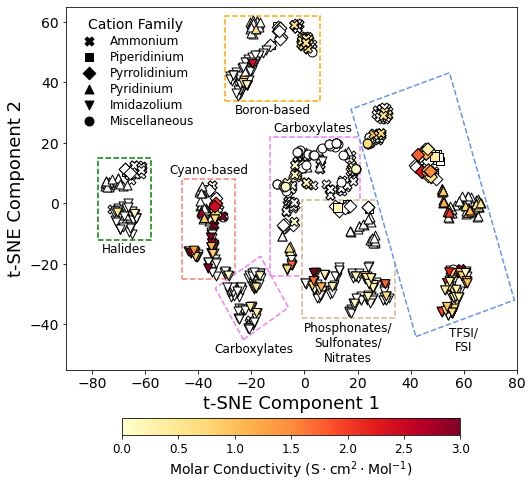

In [7]:
# Select Property of Interest

# Property, Prop_name, Units, low, high = "NE Ratio", "Nernst-Einstein Ratio", '', 0, 2
# Property, Prop_name, Units, low, high = "Viscosity", "Viscosity", '($\mathregular{Pa \cdot s}$)', 0, 2
# Property, Prop_name, Units, low, high = "Log Viscosity", "Log$\mathregular{ _{10} }$[Viscosity]"", '(Log[$\mathregular{Pa \dot s}$])', -2, 0
Property, Prop_name, Units, low, high = "molarCond_Scm2mol", "Molar Conductivity", '($\mathregular{S \cdot cm^{2} \cdot Mol^{-1}}$)', 0, 3
# Property, Prop_name, Units, low, high = "Specific_density", "Density", '($\mathregular{Kg \cdot m^{-3}}$)', 950, 1650
# Property, Prop_name, Units, low, high = "Electrical_conductivity", "Specific Conductivity", '($\mathregular{S \cdot m^{-1}}$)', 0, 2
# Property, Prop_name, Units, low, high = "Heat_capacity_at_constant_pressure", "Heat Capacity", '($\mathregular{J \cdot mol^{-1} \cdot K^{-1})}$)', 300, 700
# Property, Prop_name, Units, low, high = "Normal_melting_temperature", "Melting Temperature", '($\mathregular{ K }$)', 250, 300
# Property, Prop_name, Units, low, high = "Log A_m", "Log(A)", '($\mathregular{ Log[S \cdot cm^{2} \cdot K \cdot Mol^{-1}]}$)', 3, 12
# Property, Prop_name, Units, low, high = "Ea_m", "Activation Energy", '($\mathregular{kJ \cdot mol^{-1}}$)', 10, 60

fig,ax=plt.subplots(1,figsize=(7.5,7.075),facecolor="white")
ax.grid(color='gray',axis='both',alpha=0)
ax.set_axisbelow(True)

ax.tick_params(left=True, bottom=True, labelleft = True, labelbottom=True, labelsize=14)
ax.set_facecolor('none')

plt.scatter([], [], edgecolors='black', color='black', s=80, marker='X', label='Ammonium')
plt.scatter([], [], edgecolors='black', color='black', s=80, marker='s', label='Piperidinium')
plt.scatter([], [], edgecolors='black', color='black', s=80, marker='D', label='Pyrrolidinium')
plt.scatter([], [], edgecolors='black', color='black', s=80, marker='^', label='Pyridinium')
plt.scatter([], [], edgecolors='black', color='black', s=80, marker='v', label='Imidazolium')
plt.scatter([], [], edgecolors='black', color='black', s=80, marker='o', label='Miscellaneous')

plt.scatter(tsne_result.loc[combined_study_data['Cation Type'] == 'Ammo']['TC1'], tsne_result.loc[combined_study_data['Cation Type'] == 'Ammo']['TC2'], edgecolors='black', color='white', s=80, marker='X')
plt.scatter(tsne_result.loc[combined_study_data['Cation Type'] == 'Pipe']['TC1'], tsne_result.loc[combined_study_data['Cation Type'] == 'Pipe']['TC2'], edgecolors='black', color='white', s=80, marker='s')
plt.scatter(tsne_result.loc[combined_study_data['Cation Type'] == 'Pyrr']['TC1'], tsne_result.loc[combined_study_data['Cation Type'] == 'Pyrr']['TC2'], edgecolors='black', color='white', s=80, marker='D')
plt.scatter(tsne_result.loc[combined_study_data['Cation Type'] == 'Pyri']['TC1'], tsne_result.loc[combined_study_data['Cation Type'] == 'Pyri']['TC2'], edgecolors='black', color='white', s=80, marker='^')
plt.scatter(tsne_result.loc[combined_study_data['Cation Type'] == 'Imid']['TC1'], tsne_result.loc[combined_study_data['Cation Type'] == 'Imid']['TC2'], edgecolors='black', color='white', s=80, marker='v')
plt.scatter(tsne_result.loc[combined_study_data['Cation Type'] == '']['TC1'], tsne_result.loc[combined_study_data['Cation Type'] == '']['TC2'], edgecolors='black', color='white', s=80, marker='o')

plt.scatter(tsne_result[:175].loc[combined_study_data['Cation Type'][:175] == 'Ammo']['TC1'], tsne_result[:175].loc[combined_study_data['Cation Type'][:175] == 'Ammo']['TC2'], edgecolors='black',c=(combined_study_data[:175].loc[combined_study_data['Cation Type'][:175] == 'Ammo'][Property]), vmin=low, vmax=high, cmap='YlOrRd', s=80, marker='X')
plt.scatter(tsne_result[:175].loc[combined_study_data['Cation Type'][:175] == 'Pipe']['TC1'], tsne_result[:175].loc[combined_study_data['Cation Type'][:175] == 'Pipe']['TC2'], edgecolors='black',c=(combined_study_data[:175].loc[combined_study_data['Cation Type'][:175] == 'Pipe'][Property]), vmin=low, vmax=high, cmap='YlOrRd', s=80, marker='s')
plt.scatter(tsne_result[:175].loc[combined_study_data['Cation Type'][:175] == 'Pyrr']['TC1'], tsne_result[:175].loc[combined_study_data['Cation Type'][:175] == 'Pyrr']['TC2'], edgecolors='black',c=(combined_study_data[:175].loc[combined_study_data['Cation Type'][:175] == 'Pyrr'][Property]), vmin=low, vmax=high, cmap='YlOrRd', s=80, marker='D')
plt.scatter(tsne_result[:175].loc[combined_study_data['Cation Type'][:175] == 'Pyri']['TC1'], tsne_result[:175].loc[combined_study_data['Cation Type'][:175] == 'Pyri']['TC2'], edgecolors='black',c=(combined_study_data[:175].loc[combined_study_data['Cation Type'][:175] == 'Pyri'][Property]), vmin=low, vmax=high, cmap='YlOrRd', s=80, marker='^')
plt.scatter(tsne_result[:175].loc[combined_study_data['Cation Type'][:175] == 'Imid']['TC1'], tsne_result[:175].loc[combined_study_data['Cation Type'][:175] == 'Imid']['TC2'], edgecolors='black',c=(combined_study_data[:175].loc[combined_study_data['Cation Type'][:175] == 'Imid'][Property]), vmin=low, vmax=high, cmap='YlOrRd', s=80, marker='v')
plt.scatter(tsne_result[:175].loc[combined_study_data['Cation Type'][:175] == '']['TC1'], tsne_result[:175].loc[combined_study_data['Cation Type'][:175] == '']['TC2'], edgecolors='black',c=(combined_study_data[:175].loc[combined_study_data['Cation Type'][:175] == ''][Property]), vmin=low, vmax=high, cmap='YlOrRd', s=80, marker='o')

plt.xlabel ('t-SNE Component 1',fontsize=18)
plt.ylabel ('t-SNE Component 2',fontsize=18)

ax.set_xlim(-90, 80)
ax.set_ylim(-55, 65)

handles, labels = ax.get_legend_handles_labels()

ax.legend(title='Cation Family', frameon=True, framealpha=0, fontsize=12, title_fontsize=14,  markerscale=1, labelspacing=0.25, ncol=1, columnspacing= 0, loc=2)
cbar = plt.colorbar(location='bottom', shrink = 0.75, pad=0.1)
cbar.set_label(label=Prop_name + ' ' + Units, size=14)
cbar.ax.tick_params(labelsize=12)

Halide_box = patches.Rectangle((-78,-12), 20, 27, linewidth=1.5, edgecolor='green', facecolor='None', linestyle='--', hatch='', zorder=0)
Cyano_box = patches.Rectangle((-46,-25), 20, 33, linewidth=1.5, edgecolor='salmon', facecolor='None', linestyle='--', hatch='', zorder=0)
Boron_box = patches.Rectangle((-30,34), 36, 28, linewidth=1.5, edgecolor='orange', facecolor='None', linestyle='--', hatch='', zorder=0)
Carboxylate_box = patches.Rectangle((-23,-45), 20, 20, linewidth=1.5, edgecolor='violet', facecolor='white', linestyle='--', hatch='', zorder=0, angle=32)
Carboxylate_box_2 = patches.Rectangle((-13,-24), 34, 46, linewidth=1.5, edgecolor='violet', facecolor='None', linestyle='--', hatch='', zorder=0)
TFSI_box = patches.Rectangle((42,-44), 39, 79, linewidth=1.5, edgecolor='cornflowerblue', facecolor='white', linestyle='--', hatch='', zorder=0,  angle=18)
Phospate_Sulfate_Nitrate_box = patches.Rectangle((-1,-38), 35, 39, linewidth=1.5, edgecolor='tan', facecolor='white', linestyle='--', hatch='', zorder=0)

plt.annotate('Halides', (-68, -15), ha='center', va='center', fontsize=12)
plt.annotate('Cyano-based', (-36, 11), ha='center', va='center', fontsize=12)
plt.annotate('Boron-based', (-12, 31), ha='center', va='center', fontsize=12)
plt.annotate('Carboxylates', (-19, -48), ha='center', va='center', fontsize=12)
plt.annotate('Carboxylates', (3, 25), ha='center', va='center', fontsize=12)
plt.annotate('Phosphonates/\nSulfonates/\nNitrates', (16.5, -46), ha='center', va='center', fontsize=12)
plt.annotate('TFSI/\nFSI', (60, -45), ha='center', va='center', fontsize=12)

ax.add_patch(Halide_box)
ax.add_patch(Cyano_box)
ax.add_patch(Boron_box)
ax.add_patch(Carboxylate_box)
ax.add_patch(Carboxylate_box_2)
ax.add_patch(Phospate_Sulfate_Nitrate_box)
ax.add_patch(TFSI_box)

plt.tight_layout()